In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from scipy import signal
from scipy.io import wavfile
import sklearn
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# Загрузка экспериментальных данных и используемые методы
sample_rate, audio_data49_3 = wavfile.read('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0049S3.wav')
sample_rate, audio_data49_2 = wavfile.read('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0049S2.wav')
sample_rate, audio_data16_3 = wavfile.read('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0016S3.wav')
sample_rate, audio_data16_2 = wavfile.read('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0016S3.wav')
df = pd.read_excel('/Users/bogda/Desktop/Acoustics/Scientific/Таблицы Данных/Conducting an experiment 30_08.xlsx')

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Форма массива данных: {audio_data49_3.shape}")


def plot1 (X1, Y1, name, xlabel = '', ylabel = 'Амплитуда, у.е.'):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(name)
    plt.grid(True)
    plt.show()
    
    
def plot1_f (X1, Y1, name, freq_sep:int, xlabel = '', ylabel = 'Амплитуда, у.е.'):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(name)
    plt.grid(True)
    plt.xlim(-freq_sep,freq_sep)
    plt.show()   
    

def corr_t(data1, data2, f_filt):
    mn=min([len(data1), len(data2)])
    data1 = data1[0:mn]
    data2 = data2[0:mn]
    data1_f = ifft(data1)
    data2_f = ifft(data2)

    data1_f = filt_freq(data1_f, f_filt)
    data2_f = filt_freq(data2_f, f_filt)

    return np.fft.fftshift(fft(data1_f*np.conj(data2_f)))


def corr_f(data1, data2, f1):
    mn = min(len(data1), len(data2))
    data1_f = ifft(data1)
    data2_f = ifft(data2)
    s1 = np.zeros(mn)
    s2 = np.zeros(mn)
    f = fftfreq(mn, 1 / sample_rate)

    for i in range (0, mn):
        if f[i] > -f1:
            if f[i] < f1:
                s1[i] = data1_f[i]
                s2[i] = data2_f[i]

    fft_abs_s1 = fft((np.abs(s1))**2)
    fft_abs_s2 = fft((np.abs(s2))**2)
    
    corr_f = ifft((fft_abs_s1)*np.conj(fft_abs_s2))
    return corr_f


def count_time(first, df):
    cf_time = '15:26:16'
    cd_time = str(df.loc[first, 'Start time'])
    dur_time = str((df.loc[first, 'Duration']))
    c_time_dt = datetime.strptime(cf_time, "%H:%M:%S")
    x_time_dt = datetime.strptime(cd_time, "%H:%M:%S")
    duration = datetime.strptime(dur_time, "%H:%M:%S")
    # print(type(x_time_dt))
    delta = (x_time_dt -  c_time_dt).seconds%86400
    time_b_1 = delta
    duration_sec = duration.hour*3600 + duration.minute*60 + duration.second
    print(duration_sec)
    time_b_2 = delta + duration_sec
    return time_b_1, time_b_2, duration_sec


def cr_arr_t(first):
    t1_beg, t1_end, duration = count_time(first, df)
    t_int1 = (t > t1_beg) & (t <= t1_end)
    t1 = t[t_int1]
    f1 = fftfreq(int(len(t1)), 1 / sample_rate) # Массив частот
    
    array = [t_int1, t1, f1, duration]
    return array


def norm_max (data):
    return data/max(data)


def load_mat(data_1_str: str):
    dataset = loadmat(data_1_str)
    dat = [[element for element in upperElement] for upperElement in dataset['dataa']]
    data=[]
    
    for i in range (0,len(dat[0])):
        data.append(dat[0][i])

    if len(dat[0])%2==1:
        data=data[:len(dat[0])-1]

    return data


def first_second_part(data):
    data_first = []
    data_second = []
    for i in range(0,int(len(data)/2)):
        data_first.append(data[i])
    
    for i in range(int(len(data)/2),int(len(data))):
        data_second.append(data[i])

    return data_first, data_second


def filt_freq(data, f_filt):
    l = len(data)
    array = np.zeros(l)
    data_f = ifft(data)
    f = fftfreq(int(l), 1 / sample_rate)
    f_int = (f > -f_filt) & (f < f_filt)
    array[f_int] = data_f[f_int]
    return(fft(array))


def S_N_f (data1, data2):
    mn = min(len(data1), len(data2))
    data1 = data1[:mn]
    data2 = data2[:mn]
    data1 = filt_freq(data1, 250)
    data2 = filt_freq(data2, 250)
    #data1 = np.abs(ifft(data1))
    #data2 = np.abs(ifft(data2))
    data12 = np.sum(data1*data2)
    norm1 = np.sum(data1**2)
    norm2 = np.sum(data2**2)
    if norm1 == 0 :
        print('На ноль не делим_1')
    if norm2 == 0 :
        print('На ноль не делим_2')
    data_norm12 = np.sqrt(norm1)*np.sqrt(norm2)
    SN = data12/data_norm12
    return SN


def t_central(t, sample_rate):
    t_c = t - len(t)/sample_rate/2
    return t_c


def t_arr_for_corr_t(data):
    l = len(data)
    t = np.arange(l)/sample_rate
    t = t_central(t, sample_rate)
    return t


def mean_data(data, t_sep):
    l = len(data)
    n = int(l/sample_rate/t_sep)
    mean_ifft_data = np.zeros(int(sample_rate/n), dtype=complex)
    if l%n != 0:
        data = data[:n*sample_rate*t_sep]
    for i in range (0,n):
        data_t_sec = data[int(i*sample_rate*t_sep) : int((i+1)*sample_rate*t_sep)]
        mean_ifft_data += ifft(data_t_sec)
    
    return np.array(fft(mean_ifft_data))


def variation_data(data, t_sep, s_r = sample_rate):
    l = len(data)
    l_sec = l * s_r
    counts_per_t_sep = s_r*t_sep
    n = int(l/counts_per_t_sep)
    var_arr = []
    if (l_sec%t_sep) != 0:
        data = data[:int(n*counts_per_t_sep)]
    for i in range (0,n):
        j = int((i+1)*counts_per_t_sep)
        data_t_sec = data[:j]
        f = fftfreq(int(len(data_t_sec)), 1 / sample_rate)
        # plot1_f(f, np.abs(ifft(data_t_sec)), 'спектры частей отрезка', 1000)
        variation = np.std(np.abs(ifft(data_t_sec)))/np.mean(np.abs(ifft(data_t_sec)))
        var_arr.append(variation)
    return var_arr



t = np.arange(int(len(audio_data49_3)))/sample_rate # Массив времен

Частота дискретизации: 44100 Гц
Форма массива данных: (189858816,)


In [18]:
# Создание массивов, используемых в обработке
t_f_arr_1 = cr_arr_t(49)
t_f_arr_2 = cr_arr_t(50)
audio_data49_3_1 = audio_data49_3[t_f_arr_1[0]]
audio_data49_3_2 = audio_data49_3[t_f_arr_2[0]]

audio_data49_2_1 = audio_data49_2[t_f_arr_1[0]]
audio_data49_2_2 = audio_data49_2[t_f_arr_2[0]]


#audio_data16_2_1 = audio_data16_2[t_f_arr_1[0]]
#audio_data16_2_2 = audio_data16_2[t_f_arr_2[0]]

#audio_data16_3_1 = audio_data16_3[t_f_arr_1[0]]
#audio_data16_3_2 = audio_data16_3[t_f_arr_2[0]]



min_len_1 = min(len(audio_data49_3_1),len(audio_data49_2_1))

1
720


/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_6001/3545063233.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  array[f_int] = data_f[f_int]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


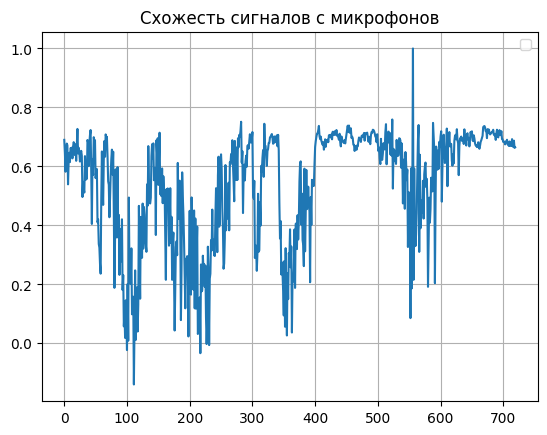

In [19]:
S_N_arr_autocorr = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    audiodata2_sec_m = mean_data(audiodata2_sec, 0.2)
    audio_data49_3_1_m = mean_data(audio_data49_3_1, 0.2)
    a = S_N_f(audio_data49_3_1_m, audiodata2_sec_m)
    S_N_arr_autocorr.append(a)

arr_sec1 = np.arange(len(S_N_arr_autocorr))
plt.plot(arr_sec1, S_N_arr_autocorr)
plt.grid(True)
plt.title('Схожесть сигналов с микрофонов')
plt.legend()
plt.show()

/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_6001/3545063233.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  array[f_int] = data_f[f_int]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


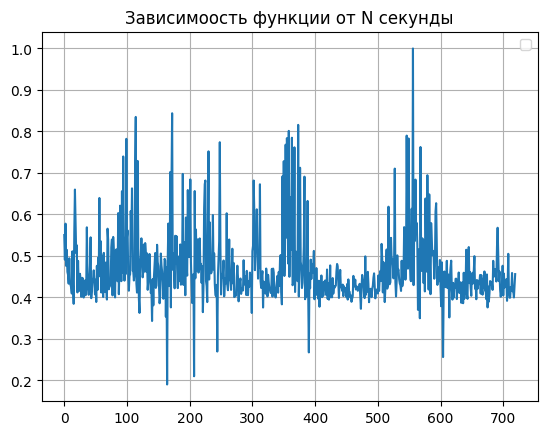

In [20]:
max_autocorr_signal = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    audiodata2_sec = mean_data(audiodata2_sec, 0.1)
    audio_data49_3_1_mean = mean_data(audio_data49_3_1, 0.1)
    max1 = np.max(np.abs(corr_t(audiodata2_sec, audio_data49_3_1_mean, 250)))
    max_signal = np.sqrt(np.max(np.abs(corr_t(audio_data49_3_1_mean, audio_data49_3_1_mean, 250)))) * np.sqrt(np.max(np.abs(corr_t(audiodata2_sec, audiodata2_sec, 250))))
    a = max1 / max_signal
    max_autocorr_signal.append(a)

l = len(max_autocorr_signal)
N_max = np.arange(l)
plt.plot(N_max, max_autocorr_signal)
plt.grid(True)
plt.title('Зависимоость функции от N секунды')
plt.legend()
plt.show()

In [ ]:
# Графики исследований
plt.plot(t_f_arr_1[1], audio_data49_3_1, color='brown', label='Small')
plt.show()

plt.plot(t_f_arr_1[1], audio_data49_2_1, color='blue', label='Small')
plt.show()

In [ ]:
t_sep = 0.1
t_arr = np.arange(t_f_arr_1[3]/t_sep)*t_sep
var_data = variation_data(audio_data49_3_1, t_sep)
plot1(t_arr, var_data, 'Зависимость стандартного отклонения от времени, %', 't, c', '%')

In [ ]:
plt.plot(t_f_arr_1[2], filt_freq(audio_data49_3_1, 600))
plt.title('Портрет DJI MATRICE 300 RTK')
plt.grid(True)
plt.xlim(-700, 700)
plt.legend()
plt.show

In [ ]:
S_N_arr_autocorr = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    audiodata2_sec = mean_data(audiodata2_sec, 0.1)
    audio_data49_3_1_m = mean_data(audio_data49_3_1, 0.1)
    a = S_N_f(audio_data49_3_1_m, audiodata2_sec)
    S_N_arr_autocorr.append(a)

corr_t_2_micr = corr_t(audio_data49_3_2, audio_data49_2_2)
t_c = t_arr_for_corr_t(corr_t_2_micr)
plt.plot(t_c, (corr_t_2_micr))
plt.grid(True)
plt.title('Временная корреляция с 2 микрофонов, при пролете около них')
plt.legend()
plt.show()

In [ ]:
corr_t_2_micr = corr_t(audio_data49_3_1, audio_data49_2_1)
t_c = t_arr_for_corr_t(corr_t_2_micr)
plt.plot(t_c, (corr_t_2_micr))
plt.grid(True)
plt.xlim(-0.02, 0.02)
plt.title('Временная корреляция с 2 микрофонов, при пролете около них')
plt.legend()
plt.show

In [ ]:
S_N_arr_1 = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    a = S_N_f(audio_data49_3_1, audiodata2_sec)
    S_N_arr_1.append(a)


n1 = np.arange(int(len(t_f_arr_2[1])/sample_rate))

In [ ]:
S_N_arr_2 = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    r1 = mean_data(audiodata2_sec, 0.1)
    r2 = mean_data(audio_data49_3_1, 0.1)
    audiodata2_sec = np.sum(r1, axis = 0)
    audio_data49_3_1_sum = np.sum(r2, axis = 0)
    a = S_N_f(audio_data49_3_1_sum, audiodata2_sec)
    S_N_arr_2.append(a)
    
n2 = np.arange(int(len(t_f_arr_2[1])/sample_rate))

In [ ]:
plt.plot(n1, S_N_arr_1)
plt.title('Зависимость схожести от шага в 1 секунду без усреднения')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(n2, S_N_arr_2)
plt.title('Зависимость схожести от шага в 1 секунду с усреднением')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
r_port = np.sum(mean_data(audio_data49_3_1, 0.1), axis = 0)
r_shum = np.sum(mean_data(audio_data49_3_2, 0.1), axis = 0)
S_N_f(r_port, audio_data49_3_2)

In [ ]:
r = mean_data(audio_data49_3_1, 0.1)
result = np.sum(r, axis=0)
f1 = fftfreq(int(len(result)), 1 / sample_rate)
plot1_f(t_f_arr_1[2], np.abs(ifft(audio_data49_3_1)), 'Фурье от секунды', 500)
plot1_f(f1, result, 'Фурье от среднего с разделение по 0.1с', 500)

In [ ]:
data1_0db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.59.31_channel_0.mat')
data1_70db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.52.03_channel_0.mat')
Fs = 48000
data_first, data_second = first_second_part(data1_0db)
mn = min(len(data_first), len(data_second))
t = np.arange(int(mn))/Fs
t_central = t - mn/Fs/2
f1 = fftfreq(mn, 1 / Fs)
f = fftfreq(min(len(data1_0db), len(data1_70db)), 1 / Fs)
c_t_parts = corr_t(data_first, data_second)
c_f_parts = corr_f(data_first, data_second, 1000)
autocorr_t = corr_t(data_first, data_first)

In [ ]:
print(S_N_f(data1_0db, data1_70db))

In [ ]:
plot1(t_central, autocorr_t, "Автокорреляция")
plot1(t_central, (c_t_parts), "Корреляция 1 и 2 половинки")

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(ifft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр автокорреляции по t 1 половинки дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(ifft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр корреляции по t 1 и 2 половинок дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()